In [1]:
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.applications import VGG16
import sklearn.metrics as metrics

Using TensorFlow backend.


In [2]:
# create a data generator
datagen = ImageDataGenerator(rescale=1./255)

In [3]:
batch_size = 128
epochs = 150
epochs_to_wait_for_improve = 10
IMG_HEIGHT = 150
IMG_WIDTH = 150
total_train = 1440
total_val = 480

In [4]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('anuka1200/train/', class_mode='binary', batch_size=batch_size, shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))
# load and iterate validation dataset
val_it = datagen.flow_from_directory('anuka1200/validation/', class_mode='binary', batch_size=64, 
                                     target_size=(IMG_HEIGHT, IMG_WIDTH))

# load and iterate test dataset
test_it = datagen.flow_from_directory('anuka1200/test/', class_mode='binary', 
                                      batch_size=64, target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 1440 images belonging to 2 classes.
Found 480 images belonging to 2 classes.
Found 480 images belonging to 2 classes.


In [5]:
# confirm the iterator works
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(128, 150, 150, 3), min=0.000, max=0.980


In [6]:
# visualize images from batches
sample_training_images, _ = next(train_it)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        #print(img.shape)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


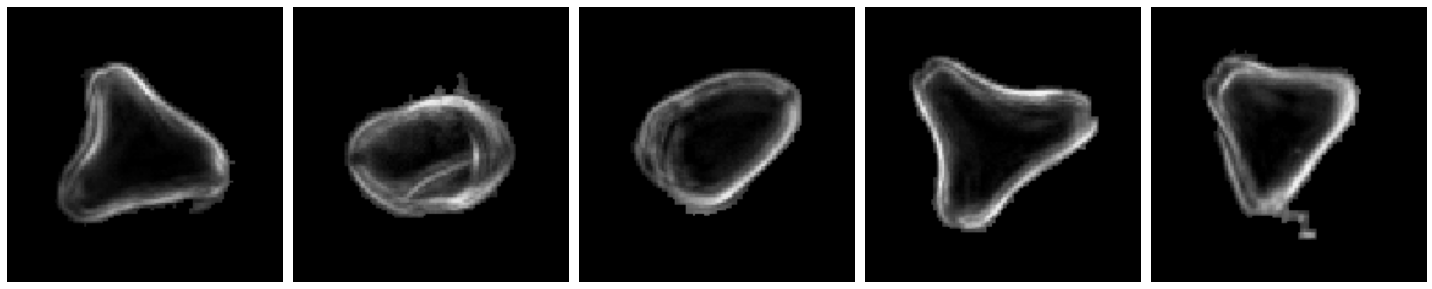

In [7]:
plotImages(sample_training_images[:5])

# Callbacks

In [8]:
class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.99):
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

# Instantiate callback
mycallback = myCallback()


early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                        patience=epochs_to_wait_for_improve,
                                                        verbose = 2)

# Modelo 1

In [9]:
# define model
# Create net architecture
modelnet_1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    #keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])


# Compile model
modelnet_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

modelnet_1.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 67500)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 135002    
Total params: 135,002
Trainable params: 135,002
Non-trainable params: 0
_________________________________________________________________


In [10]:
# fit model
history_1 = modelnet_1.fit_generator(
    train_it,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_it,
    validation_steps=total_val // batch_size,
    callbacks=[early_stopping_callback, mycallback]
)

Epoch 1/150
12/12 [==============================] - 6s 473ms/step - loss: 0.6431 - acc: 0.7271 - val_loss: 0.8544 - val_acc: 0.7229
Epoch 2/150
12/12 [==============================] - 5s 441ms/step - loss: 0.4695 - acc: 0.8597 - val_loss: 0.8832 - val_acc: 0.7708
Epoch 3/150
12/12 [==============================] - 6s 460ms/step - loss: 0.3286 - acc: 0.8660 - val_loss: 0.8034 - val_acc: 0.7771
Epoch 4/150
12/12 [==============================] - 9s 750ms/step - loss: 0.2959 - acc: 0.8910 - val_loss: 0.7249 - val_acc: 0.7750
Epoch 5/150
12/12 [==============================] - 8s 635ms/step - loss: 0.2693 - acc: 0.9021 - val_loss: 0.7121 - val_acc: 0.7771
Epoch 6/150
12/12 [==============================] - 10s 811ms/step - loss: 0.2381 - acc: 0.9014 - val_loss: 0.6950 - val_acc: 0.8000
Epoch 7/150
12/12 [==============================] - 6s 527ms/step - loss: 0.2381 - acc: 0.9014 - val_loss: 0.9428 - val_acc: 0.7771
Epoch 8/150
12/12 [==============================] - 6s 489ms/step -

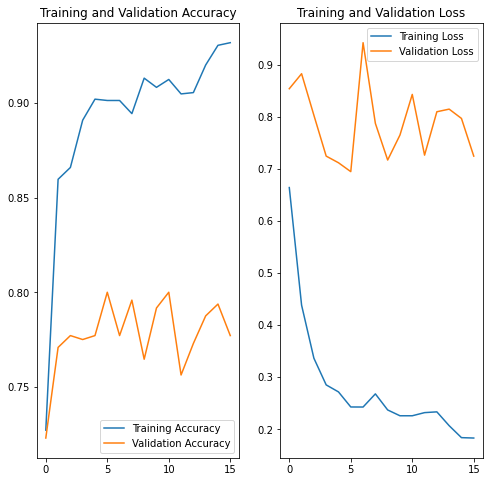

In [11]:
# Visualize training results
acc_1 = history_1.history['acc']
val_acc_1 = history_1.history['val_acc']

loss_1 = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']

epochs_range_1 = range(len(acc_1))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_1, acc_1, label='Training Accuracy')
plt.plot(epochs_range_1, val_acc_1, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_1, loss_1, label='Training Loss')
plt.plot(epochs_range_1, val_loss_1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [12]:
test_loss_1, test_acc_1 = modelnet_1.evaluate(test_it, verbose=2)

print('\nTest accuracy:', test_acc_1)
print('\nTest loss:', test_loss_1)

# evaluate model
loss_1 = modelnet_1.evaluate_generator(test_it, steps=24)
print(loss_1)

 - 2s - loss: 0.4142 - acc: 0.8417

Test accuracy: 0.84166664

Test loss: 0.4142143577337265
[0.4142143577337265, 0.84166664]


In [13]:
# Confusion matrix

Y_pred = modelnet_1.predict(test_it, test_it.samples / batch_size)
val_preds = np.argmax(Y_pred, axis=1)

val_trues =val_it.classes
cm = metrics.confusion_matrix(val_trues, val_preds)
cm

array([[140, 100],
       [128, 112]], dtype=int64)

# Modelo 2

In [14]:
# define model
# Create net 
modelnet_2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')

])

# Compile model
modelnet_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


modelnet_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               34560512  
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 34,626,434
Trainable params: 34,626,434
Non-trainable params: 0
_________________________________________________________________


In [15]:
# fit model
history_2 = modelnet_2.fit_generator(
    train_it,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_it,
    validation_steps=total_val // batch_size,
    callbacks=[early_stopping_callback, mycallback]
)

Epoch 1/150
12/12 [==============================] - 26s 2s/step - loss: 2.9031 - acc: 0.6618 - val_loss: 1.1831 - val_acc: 0.7396
Epoch 2/150
12/12 [==============================] - 46s 4s/step - loss: 0.6066 - acc: 0.8271 - val_loss: 0.7186 - val_acc: 0.7937
Epoch 3/150
12/12 [==============================] - 28s 2s/step - loss: 0.2894 - acc: 0.8799 - val_loss: 0.6392 - val_acc: 0.7958
Epoch 4/150
12/12 [==============================] - 24s 2s/step - loss: 0.2359 - acc: 0.9035 - val_loss: 0.5515 - val_acc: 0.8167
Epoch 5/150
12/12 [==============================] - 34s 3s/step - loss: 0.1916 - acc: 0.9271 - val_loss: 0.6146 - val_acc: 0.7854
Epoch 6/150
12/12 [==============================] - 32s 3s/step - loss: 0.1976 - acc: 0.9208 - val_loss: 0.5075 - val_acc: 0.8146
Epoch 7/150
12/12 [==============================] - 25s 2s/step - loss: 0.1595 - acc: 0.9410 - val_loss: 0.5653 - val_acc: 0.8146
Epoch 8/150
12/12 [==============================] - 25s 2s/step - loss: 0.1237 - a

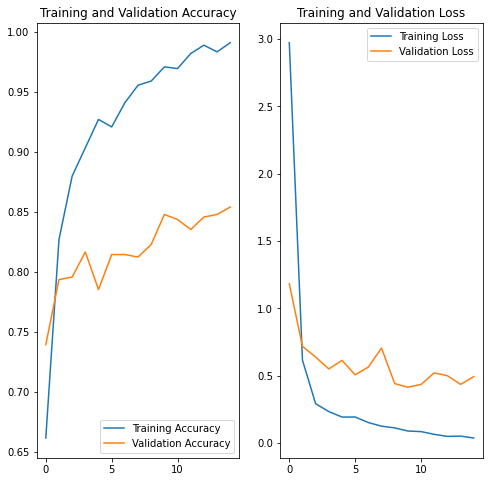

In [16]:
# Visualize training results
acc_2 = history_2.history['acc']
val_acc_2 = history_2.history['val_acc']

loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']

epochs_range_2 = range(len(acc_2))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_2, acc_2, label='Training Accuracy')
plt.plot(epochs_range_2, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_2, loss_2, label='Training Loss')
plt.plot(epochs_range_2, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [17]:
# Accuracy
test_loss_2, test_acc_2 = modelnet_2.evaluate(test_it, verbose=2)

print('\nTest accuracy:', test_acc_2)
print('Test loss:', test_loss_2)

# evaluate model
loss_2 = modelnet_2.evaluate_generator(test_it, steps=24)
loss_2

 - 2s - loss: 0.3631 - acc: 0.8833

Test accuracy: 0.8833333
Test loss: 0.3631491456180811


[0.3303526770323515, 0.8833333]

In [18]:
# Confusion matrix

Y_pred = modelnet_2.predict(test_it, test_it.samples / batch_size)
val_preds = np.argmax(Y_pred, axis=1)

val_trues =val_it.classes
cm = metrics.confusion_matrix(val_trues, val_preds)
cm

array([[141,  99],
       [129, 111]], dtype=int64)

# Modelo 3

In [19]:
modelnet_3 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    #MaxPooling2D(),
    #Conv2D(32, 3, padding='same', activation='relu'),
    #MaxPooling2D(),
    #Conv2D(64, 3, padding='same', activation='relu'),
    #MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

In [20]:
modelnet_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


modelnet_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
flatten_2 (Flatten)          (None, 360000)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               46080128  
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 46,080,834
Trainable params: 46,080,834
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Fit the model
history_3 = modelnet_3.fit_generator(
    train_it,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_it,
    validation_steps=total_val // batch_size,
    callbacks=[early_stopping_callback, mycallback]
)


Epoch 1/150
12/12 [==============================] - 68s 6s/step - loss: 1.6153 - acc: 0.7396 - val_loss: 1.3363 - val_acc: 0.7063
Epoch 2/150
12/12 [==============================] - 65s 5s/step - loss: 0.4905 - acc: 0.8639 - val_loss: 1.0882 - val_acc: 0.7688
Epoch 3/150
12/12 [==============================] - 79s 7s/step - loss: 0.3029 - acc: 0.8861 - val_loss: 0.6164 - val_acc: 0.7771
Epoch 4/150
12/12 [==============================] - 79s 7s/step - loss: 0.2139 - acc: 0.9201 - val_loss: 0.6313 - val_acc: 0.8062
Epoch 5/150
12/12 [==============================] - 84s 7s/step - loss: 0.1599 - acc: 0.9410 - val_loss: 0.7340 - val_acc: 0.8021
Epoch 6/150
12/12 [==============================] - 66s 6s/step - loss: 0.1361 - acc: 0.9576 - val_loss: 0.7399 - val_acc: 0.8125
Epoch 7/150
12/12 [==============================] - 80s 7s/step - loss: 0.1020 - acc: 0.9701 - val_loss: 0.7429 - val_acc: 0.8104
Epoch 8/150
12/12 [==============================] - 89s 7s/step - loss: 0.0774 - a

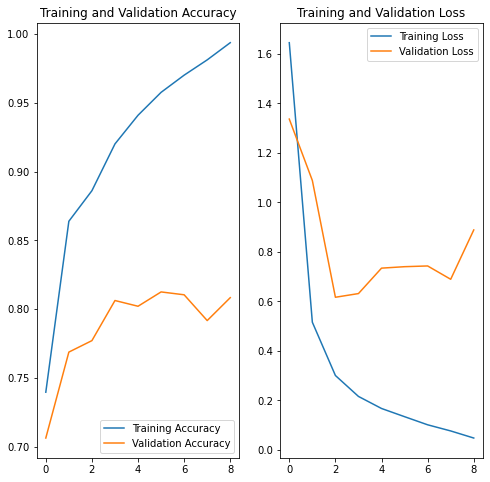

In [22]:
# Visualize training results
acc_3 = history_3.history['acc']
val_acc_3 = history_3.history['val_acc']

loss_3 = history_3.history['loss']
val_loss_3 = history_3.history['val_loss']

epochs_range_3 = range(len(acc_3))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_3, acc_3, label='Training Accuracy')
plt.plot(epochs_range_3, val_acc_3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_3, loss_3, label='Training Loss')
plt.plot(epochs_range_3, val_loss_3, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [23]:
test_loss_3, test_acc_3 = modelnet_3.evaluate(test_it, verbose=5)

print('\nTest accuracy:', test_acc_3)
print('\nTest loss:', test_loss_3)

# evaluate model
loss_3 = modelnet_3.evaluate_generator(test_it, steps=24)
loss_3


Test accuracy: 0.81875

Test loss: 0.6111448928713799


[0.5660116374492645, 0.81875]

In [24]:
# Confusion matrix

Y_pred = modelnet_3.predict(test_it, test_it.samples / batch_size)
val_preds = np.argmax(Y_pred, axis=1)

val_trues =val_it.classes
cm = metrics.confusion_matrix(val_trues, val_preds)
cm

array([[162,  78],
       [157,  83]], dtype=int64)

# Modelo 3 mejorado

In [25]:
modelnet_3_enhanced = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.15),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')
])


modelnet_3_enhanced.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


modelnet_3_enhanced.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)        18496     
___________________________

In [26]:
# Fit the model
history_3_enhanced = modelnet_3_enhanced.fit_generator(
    train_it,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_it,
    validation_steps=total_val // batch_size,
    callbacks=[early_stopping_callback, mycallback]
)


Epoch 1/150
12/12 [==============================] - 99s 8s/step - loss: 0.5529 - acc: 0.7181 - val_loss: 0.5175 - val_acc: 0.7521
Epoch 2/150
12/12 [==============================] - 104s 9s/step - loss: 0.3745 - acc: 0.8514 - val_loss: 0.5300 - val_acc: 0.7312
Epoch 3/150
12/12 [==============================] - 100s 8s/step - loss: 0.3260 - acc: 0.8715 - val_loss: 0.5352 - val_acc: 0.7771
Epoch 4/150
12/12 [==============================] - 101s 8s/step - loss: 0.2682 - acc: 0.8972 - val_loss: 0.6191 - val_acc: 0.7979
Epoch 5/150
12/12 [==============================] - 88s 7s/step - loss: 0.2207 - acc: 0.9062 - val_loss: 0.5806 - val_acc: 0.8062
Epoch 6/150
12/12 [==============================] - 86s 7s/step - loss: 0.2182 - acc: 0.9194 - val_loss: 0.6134 - val_acc: 0.7979
Epoch 7/150
12/12 [==============================] - 97s 8s/step - loss: 0.2099 - acc: 0.9104 - val_loss: 0.5858 - val_acc: 0.8083
Epoch 8/150
12/12 [==============================] - 100s 8s/step - loss: 0.2340

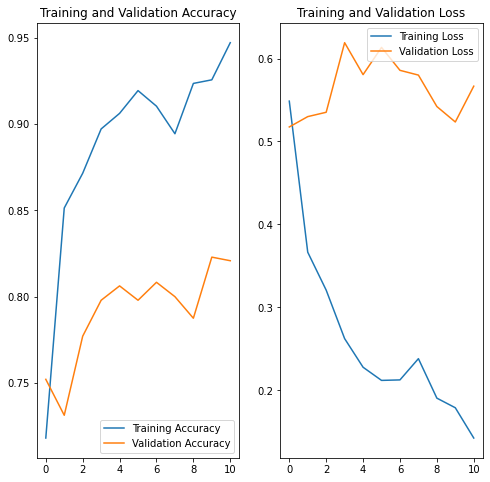

In [27]:
# Visualize training results
acc_3_enhanced = history_3_enhanced.history['acc']
val_acc_3_enhanced = history_3_enhanced.history['val_acc']

loss_3_enhanced = history_3_enhanced.history['loss']
val_loss_3_enhanced = history_3_enhanced.history['val_loss']

epochs_range_3_enhanced = range(len(acc_3_enhanced))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_3_enhanced, acc_3_enhanced, label='Training Accuracy')
plt.plot(epochs_range_3_enhanced, val_acc_3_enhanced, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_3_enhanced, loss_3_enhanced, label='Training Loss')
plt.plot(epochs_range_3_enhanced, val_loss_3_enhanced, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [28]:
test_loss_3_enhanced, test_acc_3_enhanced = modelnet_3_enhanced.evaluate(test_it, verbose=5)

print('\nTest accuracy:', test_acc_3_enhanced)
print('\nTest loss:', test_loss_3_enhanced)

# evaluate model
loss_3_enhanced = modelnet_3_enhanced.evaluate_generator(test_it, steps=24)
loss_3_enhanced


Test accuracy: 0.85625

Test loss: 0.3444731552153826


[0.3265208452939987, 0.85625]

In [29]:
# Confusion matrix

Y_pred = modelnet_3_enhanced.predict(test_it, test_it.samples / batch_size)
val_preds = np.argmax(Y_pred, axis=1)

val_trues =val_it.classes
cm = metrics.confusion_matrix(val_trues, val_preds)
cm

array([[135, 105],
       [148,  92]], dtype=int64)

# Training accuracy graph

In [30]:
# Visualize training results
acc_1 = history_1.history['acc']
acc_2 = history_2.history['acc']
acc_3 = history_3.history['acc']
acc_3_enhanced = history_3_enhanced.history['acc']
val_acc_1 = history_1.history['val_acc']
val_acc_2 = history_2.history['val_acc']
val_acc_3 = history_3.history['val_acc']
val_acc_3_enhanced = history_3_enhanced.history['val_acc']

Text(0.5, 1.0, 'Training Accuracy')

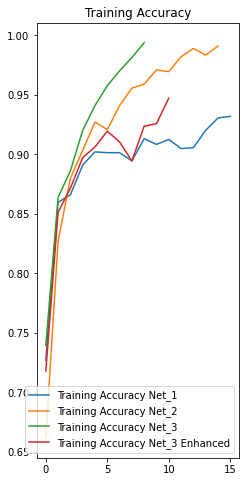

In [31]:
#epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_1, acc_1, label='Training Accuracy Net_1')
plt.plot(epochs_range_2, acc_2, label='Training Accuracy Net_2')
plt.plot(epochs_range_3, acc_3, label='Training Accuracy Net_3')
plt.plot(epochs_range_3_enhanced, acc_3_enhanced, label='Training Accuracy Net_3 Enhanced')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

Text(0.5, 1.0, 'Validation Accuracy')

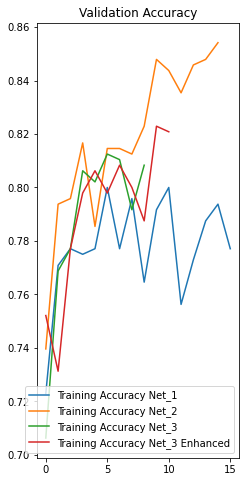

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_1, val_acc_1, label='Training Accuracy Net_1')
plt.plot(epochs_range_2, val_acc_2, label='Training Accuracy Net_2')
plt.plot(epochs_range_3, val_acc_3, label='Training Accuracy Net_3')
plt.plot(epochs_range_3_enhanced, val_acc_3_enhanced, label='Training Accuracy Net_3 Enhanced')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

# Loss

In [33]:
loss_1 = history_1.history['loss']
loss_2 = history_2.history['loss']
loss_3 = history_3.history['loss']
loss_3_enhanced = history_3_enhanced.history['loss']
val_loss_1 = history_1.history['val_loss']
val_loss_2 = history_2.history['val_loss']
val_loss_3 = history_3.history['val_loss']
val_loss_3_enhanced = history_3_enhanced.history['val_loss']

Text(0.5, 1.0, 'Training Loss')

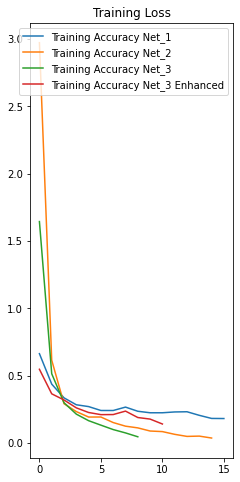

In [34]:
#epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_1, loss_1, label='Training Accuracy Net_1')
plt.plot(epochs_range_2, loss_2, label='Training Accuracy Net_2')
plt.plot(epochs_range_3, loss_3, label='Training Accuracy Net_3')
plt.plot(epochs_range_3_enhanced, loss_3_enhanced, label='Training Accuracy Net_3 Enhanced')
plt.legend(loc='upper right')
plt.title('Training Loss')

Text(0.5, 1.0, 'Validation Loss')

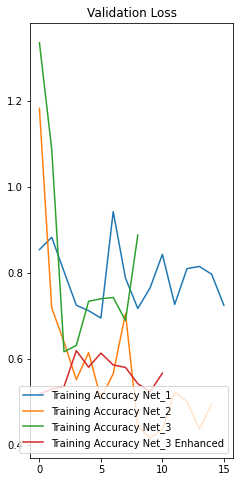

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_1, val_loss_1, label='Training Accuracy Net_1')
plt.plot(epochs_range_2, val_loss_2, label='Training Accuracy Net_2')
plt.plot(epochs_range_3, val_loss_3, label='Training Accuracy Net_3')
plt.plot(epochs_range_3_enhanced, val_loss_3_enhanced, label='Training Accuracy Net_3 Enhanced')
plt.legend(loc='lower right')
plt.title('Validation Loss')

# Accuracy on test set

In [36]:
print('Test accuracy first model:', test_acc_1)
print('Test accuracy second model:', test_acc_2)
print('Test accuracy third model:', test_acc_3)
print('Test accuracy third model enhanced:', test_acc_3_enhanced)

Test accuracy first model: 0.84166664
Test accuracy second model: 0.8833333
Test accuracy third model: 0.81875
Test accuracy third model enhanced: 0.85625
